<a href="https://colab.research.google.com/github/Francesco0101/Computer-Vision-Project-on-Ground-To-Aerial-Matching/blob/main/CV_project_on_Cross_image_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [37]:
%%capture
!pip install gdown
!pip install rarfile
!pip install datasets opencv-contrib-python opencv-python ipywidgets scipy
!pip install pytorch_lightning
!pip install transformers torch pillow matplotlib

In [38]:
import gdown
import zipfile
import os
from google.colab.patches import cv2_imshow #rimuovere se online
import cv2
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import csv
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import random_split
import logging
from collections import OrderedDict
import torchvision
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from torch import optim
from torch.utils.data.distributed import DistributedSampler
from pytorch_lightning.callbacks.progress import RichProgressBar
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, Mask2FormerForUniversalSegmentation

In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
# torch.set_float32_matmul_precision('medium') # solo in locale

In [41]:
seed_everything(42, workers=True)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

#CVUSA Dataset

To load directly without drive

In [ ]:
"""

!pip install rarfile
!gdown --id 17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_

"""

'\n\n!pip install rarfile\n!gdown --id 17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_\n\n'

In [ ]:
# import rarfile
# import os

# # Percorso del file RAR
# file_rar = "/content/drive/MyDrive/CV/CVUSA_subset.rar"

# # Directory di destinazione per l'estrazione
# extract_path = "/content/CVUSA_subset"

# # Estrarre il file RAR
# with rarfile.RarFile(file_rar, 'r') as rar:
#     # Crea la directory di destinazione se non esiste
#     os.makedirs(extract_path, exist_ok=True)
#     # Estrai tutto nella directory di destinazione
#     rar.extractall(extract_path)

# print("Estrazione completata.")

In [42]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


##Needed Paths

In [47]:
# Percorsi delle directory
import re
#Francesco
bingmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/bingmap'
streetview_dir = '/content/drive/MyDrive/CV/CVUSA_subset/streetview'
cvusa_dir = '/content/drive/MyDrive/CV/CVUSA_subset'
csv_path = '/content/drive/MyDrive/CV/CVUSA_subset/file_paths.csv'
bingmap_depth_dir = '/content/drive/MyDrive/CV/CVUSA_subset/depth/bingmap'
streetview_depth_dir = '/content/drive/MyDrive/CV/CVUSA_subset/depth/streetview'
bingmap_segmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/segmap_new/bingmap'
streetview_segmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/segmap_new/streetview'
bingmap_sift_dir = '/content/drive/MyDrive/CV/CVUSA_subset/sift_img/bingmap'
streetview_sift_dir = '/content/drive/MyDrive/CV/CVUSA_subset/sift_img/streetview'
# #Simone Local
# bingmap_dir = 'CVUSA_subset/bingmap'
# streetview_dir = 'CVUSA_subset/streetview'
# bingmap_sift_dir = 'CVUSA_subset/sift/bingmap'
# streetview_sift_dir = 'CVUSA_subset/sift/streetview'
# cvusa_dir = 'CVUSA_subset'
# csv_path = 'CVUSA_subset/file_paths.csv'
# bingmap_depth_dir = 'CVUSA_subset/depth/bingmap'
# streetview_depth_dir = 'CVUSA_subset/depth/streetview'
# bingmap_segmap_dir = 'CVUSA_subset/segmap_new/bingmap'
# streetview_segmap_dir = 'CVUSA_subset/segmap_new/streetview'


In [ ]:
Blocco Manuale

##SIFT

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Definisci le liste per salvare i descrittori
Aerial_sift = []
Ground_sift = []

def extract_sift_descriptor(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()

    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        return descriptors
    else:
        print("No descriptors found.")
        return None

# Esempio di utilizzo per estrarre e salvare i descrittori SIFT

for file in tqdm(bingmap_files):
    if file.endswith(".png"):
        image_path = os.path.join(bingmap_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.savez_compressed(f"drive/MyDrive/CVUSA_subset/sift/bingmap/sift_descriptors_{file[:-4]}.npz", sift_descriptor)

for file in tqdm(streetview_files):
    if file.endswith(".jpg"):
        image_path = os.path.join(streetview_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.savez_compressed(f"drive/MyDrive/CVUSA_subset/sift/streetview/sift_descriptors_{file[:-4]}.npz", sift_descriptor)



  0%|          | 12/8862 [00:03<40:13,  3.67it/s]


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from google.colab.patches import cv2_imshow
# Definisci le liste per salvare i descrittori
Aerial_sift = []
Ground_sift = []

def extract_sift_keypoints(image_path, output_path):
    # Leggi l'immagine in scala di grigi
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Crea un oggetto SIFT
    sift = cv2.SIFT_create()

    # Trova keypoints e descrittori
    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        # Disegna i keypoints sull'immagine originale
        image_with_keypoints = cv2.drawKeypoints(
            image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        # Visualizza l'immagine con i keypoints
        # Salva l'immagine con i keypoints disegnati
        cv2.imwrite(output_path, image_with_keypoints)
    else:
        print("No descriptors found.")
        image_try = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(output_path, image_try)



# Lista dei file
bingmap_files = os.listdir(bingmap_dir)
streetview_files = os.listdir(streetview_dir)

# Esempio di utilizzo per estrarre e salvare le immagini con SIFT visualizzato
for file in tqdm(bingmap_files):
    if file.endswith(".png"):
        image_path = os.path.join(bingmap_dir, file)
        output_path = os.path.join("drive/MyDrive/CV/CVUSA_subset/sift_img/bingmap/", f"sift_visualized_{file}")
        extract_sift_keypoints(image_path, output_path)

for file in tqdm(streetview_files):
    if file.endswith(".jpg"):
        image_path = os.path.join(streetview_dir, file)
        output_path = os.path.join("drive/MyDrive/CV/CVUSA_subset/sift_img/streetview/", f"sift_visualized_{file}")
        extract_sift_keypoints(image_path, output_path)


 11%|█         | 944/8862 [14:45<2:10:18,  1.01it/s]

In [ ]:
# import numpy as np

# # Esempio di caricamento dei descrittori SIFT da un file .npz
# file_path = "drive/MyDrive/CVUSA_subset/sift/bingmap/sift_descriptors_input0000008.npz"

# # Carica il file .npz
# data = np.load(file_path)

# # Estrai i descrittori
# sift_descriptors = data['arr_0']  # La chiave 'arr_0' è il nome predefinito per l'array salvato

# print(sift_descriptors)

[[ 7.  0.  0. ...  8.  0.  0.]
 [ 0.  0.  0. ... 22.  7. 36.]
 [ 0.  1.  5. ...  0. 18. 76.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [95. 21.  4. ...  8.  1.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [ ]:
import numpy as np

# Esempio di caricamento di un descriptor SIFT da un file .npy
filename = "/sift/bingmap/sift_descriptors_input0000008.npy"  # Assicurati di specificare il percorso completo se non è nello stesso script

# Carica il descriptor SIFT dal file .npy
sift_descriptor = np.load(filename)

# Ora puoi utilizzare il descriptor SIFT per qualsiasi operazione desideri
print("Shape of loaded descriptor:", sift_descriptor.shape)
print("Example of loaded descriptor:", sift_descriptor[:10])  # Esempio di stampa dei primi 10 elementi del descriptor

Shape of loaded descriptor: (1143, 128)
Example of loaded descriptor: [[ 7.  0.  0. ...  8.  0.  0.]
 [ 0.  0.  0. ... 22.  7. 36.]
 [ 0.  1.  5. ...  0. 18. 76.]
 ...
 [82. 35.  9. ...  3.  5.  0.]
 [ 6. 13.  2. ... 53.  7.  3.]
 [33. 31. 27. ... 28. 78. 51.]]


##  Depth and Segmap


In [ ]:
depth_image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")

# Load segmentation model
seg_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-ade-semantic")
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-ade-semantic")

In [ ]:
# Define directories
bingmap_dir = '/CVUSA_subset/bingmap'
streetview_dir = '/CVUSA_subset/streetview'

# Create output directories
depth_aerial_dir = '/CVUSA_subset/depth_aerial'
seg_aerial_dir = '/CVUSA_subset/seg_aerial'
depth_ground_dir = '/CVUSA_subset/depth_ground'
seg_ground_dir = '/CVUSA_subset/seg_ground'

os.makedirs(depth_aerial_dir, exist_ok=True)
os.makedirs(seg_aerial_dir, exist_ok=True)
os.makedirs(depth_ground_dir, exist_ok=True)
os.makedirs(seg_ground_dir, exist_ok=True)

# List files in each directory
bingmap_files = [os.path.join(bingmap_dir, f) for f in os.listdir(bingmap_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
streetview_files = [os.path.join(streetview_dir, f) for f in os.listdir(streetview_dir) if f.endswith(('png', 'jpg', 'jpeg'))]



def process_image(image_path, depth_output_dir, seg_output_dir):
    image = Image.open(image_path)

    # Process depth estimation
    depth_inputs = depth_image_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        depth_outputs = depth_model(**depth_inputs)
        predicted_depth = depth_outputs.predicted_depth
        depth_prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()
    depth_output_path = os.path.join(depth_output_dir, os.path.basename(image_path))
    depth_image = Image.fromarray((depth_prediction * 255 / depth_prediction.max()).astype('uint8'))
    depth_image.save(depth_output_path)

    # Process segmentation
    seg_inputs = seg_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        seg_outputs = seg_model(**seg_inputs)
    predicted_segmentation = seg_processor.post_process_semantic_segmentation(seg_outputs, target_sizes=[image.size[::-1]])[0]
    seg_output_path = os.path.join(seg_output_dir, os.path.basename(image_path))
    seg_image = Image.fromarray(predicted_segmentation.numpy().astype('uint8'))
    seg_image.save(seg_output_path)

In [ ]:
for image_path in tqdm(bingmap_files):
    process_image(image_path, depth_aerial_dir, seg_aerial_dir)

In [ ]:
for image_path in tqdm(streetview_files):
    process_image(image_path, depth_ground_dir, seg_ground_dir)

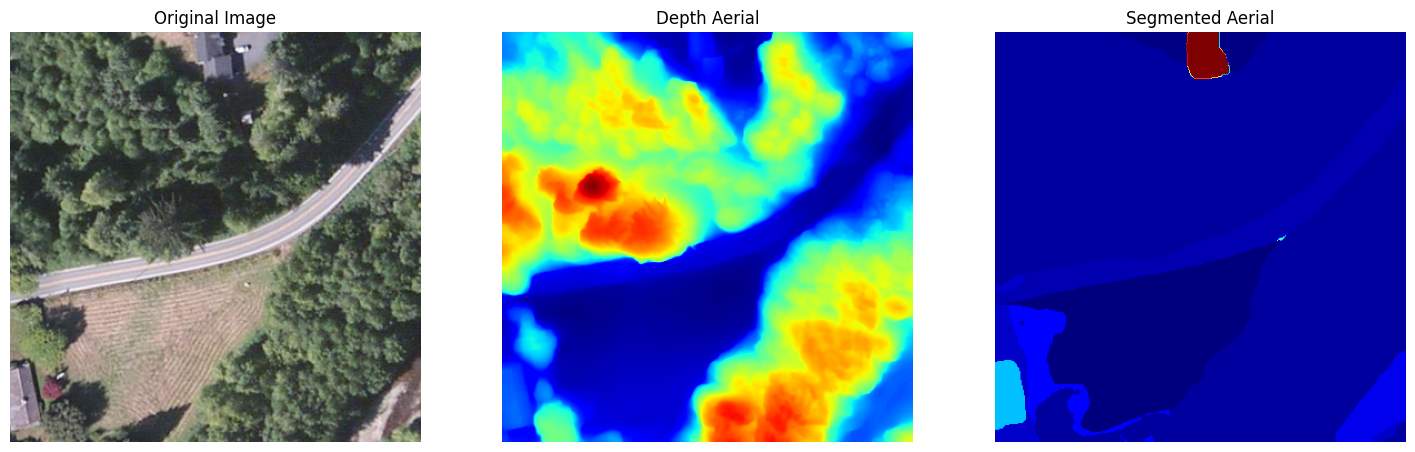

In [148]:
# Load images
image = Image.open("drive/MyDrive/CV/CVUSA_subset/depth/bingmap/input0000068.png")
image_seg = Image.open("drive/MyDrive/CV/CVUSA_subset/segmap_new/bingmap/input0000068.png")
image_og = Image.open("drive/MyDrive/CV/CVUSA_subset/bingmap/input0000068.png")

# Create a figure with a specified size
plt.figure(figsize=(18, 6))

# Display the original image in the first subplot
plt.subplot(1, 3, 1)
plt.imshow(image_og,  cmap='gnuplot')
plt.title('Original Image')
plt.axis('off')

# Display the depth aerial image in the second subplot
plt.subplot(1, 3, 2)
plt.imshow(image,  cmap='gnuplot')
plt.title('Depth Aerial')
plt.axis('off')

# Display the segmented aerial image in the third subplot
plt.subplot(1, 3, 3)
plt.imshow(image_seg, cmap='gnuplot')
plt.title('Segmented Aerial')
plt.axis('off')

# Show the plot
plt.show()


##CSV creation

In [48]:
import os
import re
import csv

# Function to extract numeric identifier from filenames
def extract_identifier(filename):
    match = re.search(r'\d+', filename)
    return match.group() if match else None

# Read files from directories
bingmap_files = sorted(os.listdir(bingmap_dir))
streetview_files = sorted(os.listdir(streetview_dir))
bingmap_sift_files = sorted(os.listdir(bingmap_sift_dir))
streetview_sift_files = sorted(os.listdir(streetview_sift_dir))
streetview_depth_files = sorted(os.listdir(streetview_depth_dir))
bingmap_depth_files = sorted(os.listdir(bingmap_depth_dir))
streetview_segmap_files = sorted(os.listdir(streetview_segmap_dir))
bingmap_segmap_files = sorted(os.listdir(bingmap_segmap_dir))

# Print the number of files found in each directory
print(len(bingmap_files))
print(len(streetview_files))
print(len(bingmap_sift_files))
print(len(streetview_sift_files))
print(len(streetview_depth_files))
print(len(bingmap_depth_files))
print(len(streetview_segmap_files))
print(len(bingmap_segmap_files))

# Create dictionaries to map identifiers to filenames
bingmap_dict = {extract_identifier(f): f for f in bingmap_files}
streetview_dict = {extract_identifier(f): f for f in streetview_files}
bingmap_sift_dict = {extract_identifier(f): f for f in bingmap_sift_files}
streetview_sift_dict = {extract_identifier(f): f for f in streetview_sift_files}
streetview_depth_dict = {extract_identifier(f): f for f in streetview_depth_files}
bingmap_depth_dict = {extract_identifier(f): f for f in bingmap_depth_files}
streetview_segmap_dict = {extract_identifier(f): f for f in streetview_segmap_files}
bingmap_segmap_dict = {extract_identifier(f): f for f in bingmap_segmap_files}

# Find all identifiers
all_identifiers = set(bingmap_dict.keys()).union(
    streetview_dict.keys(),
    bingmap_sift_dict.keys(),
    streetview_sift_dict.keys(),
    streetview_depth_dict.keys(),
    bingmap_depth_dict.keys(),
    streetview_segmap_dict.keys(),
    bingmap_segmap_dict.keys()
)

# Write file paths to CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    for identifier in all_identifiers:
        bingmap_file = bingmap_dict.get(identifier, "None")
        streetview_file = streetview_dict.get(identifier, "None")
        bingmap_sift_file = bingmap_sift_dict.get(identifier, "None")
        streetview_sift_file = streetview_sift_dict.get(identifier, "None")
        streetview_depth_file = streetview_depth_dict.get(identifier, "None")
        bingmap_depth_file = bingmap_depth_dict.get(identifier, "None")
        streetview_segmap_file = streetview_segmap_dict.get(identifier, "None")
        bingmap_segmap_file = bingmap_segmap_dict.get(identifier, "None")

        bingmap_path = f"{bingmap_dir}/{bingmap_file}" if bingmap_file != "None" else "None"
        streetview_path = f"{streetview_dir}/{streetview_file}" if streetview_file != "None" else "None"
        bingmap_sift_path = f"{bingmap_sift_dir}/{bingmap_sift_file}" if bingmap_sift_file != "None" else "None"
        streetview_sift_path = f"{streetview_sift_dir}/{streetview_sift_file}" if streetview_sift_file != "None" else "None"
        bingmap_depth_path = f"{bingmap_depth_dir}/{bingmap_depth_file}" if bingmap_depth_file != "None" else "None"
        streetview_depth_path = f"{streetview_depth_dir}/{streetview_depth_file}" if streetview_depth_file != "None" else "None"
        bingmap_segmap_path = f"{bingmap_segmap_dir}/{bingmap_segmap_file}" if bingmap_segmap_file != "None" else "None"
        streetview_segmap_path = f"{streetview_segmap_dir}/{streetview_segmap_file}" if streetview_segmap_file != "None" else "None"

        writer.writerow([bingmap_path, streetview_path, bingmap_sift_path, streetview_sift_path, bingmap_depth_path, streetview_depth_path, bingmap_segmap_path, streetview_segmap_path])

print(f"CSV creato con successo in {csv_path}")



8862
8862
8855
8862
8862
8862
8862
8862
CSV creato con successo in /content/drive/MyDrive/CV/CVUSA_subset/file_paths.csv


# Dataset

In [127]:
class CVUSADatasetPath(Dataset):
    def __init__(self, cvusa_dir, directory):
        self.directory = directory
        self.cvusa_dir = cvusa_dir
        self.aerial_paths = []
        self.ground_paths = []
        self.aerial_sift_paths = []
        self.ground_sift_paths = []
        self.aerial_depth_paths = []
        self.ground_depth_paths = []
        self.aerial_segmap_paths = []
        self.ground_segmap_paths = []

        with open(self.directory, mode='r') as file:
          csv_reader = csv.reader(file, delimiter=',')
          for row in csv_reader:
              aerial_path = row[0]
              ground_path = row[1]
              aerial_sift_path = row[2]
              ground_sift_path = row[3]
              aerial_depth_path = row[4]
              ground_depth_path = row[5]
              aerial_segmap_path = row[6]
              ground_segmap_path = row[7]

              self.aerial_paths.append(aerial_path)
              self.ground_paths.append(ground_path)
              self.aerial_sift_paths.append(aerial_sift_path)
              self.ground_sift_paths.append(ground_sift_path)
              self.aerial_depth_paths.append(aerial_depth_path)
              self.ground_depth_paths.append(ground_depth_path)
              self.aerial_segmap_paths.append(aerial_segmap_path)
              self.ground_segmap_paths.append(ground_segmap_path)




    def __len__(self):
        return len(self.aerial_paths) # any image path is good

    def __getitem__(self, idx):
        return self.ground_paths[idx], self.aerial_paths[idx], self.ground_sift_paths[idx], self.aerial_sift_paths[idx], self.ground_depth_paths[idx], self.aerial_depth_paths[idx], self.ground_segmap_paths[idx], self.aerial_segmap_paths[idx]

In [ ]:
# class CVUSADataset(pl.LightningDataModule):
#     def __init__(self, cvusa_dir, directory, batch_size=32, transform = True):
#         super().__init__()
#         self.batch_size = batch_size
#         self.cvusa_dir = cvusa_dir
#         self.directory = directory
#         self.transformation = transform

#     def setup(self, stage=None):
#         self.dataset = CVUSADatasetPath(self.cvusa_dir, self.directory)
#         self.train_dataset, self.val_dataset, self.test_dataset = random_split(self.dataset, [0.8, 0.1, 0.1])

#     def transform(self, set_type):
#       transform = None
#       if self.transformation == False:
#         transform = transforms.Compose([
#             transforms.ToTensor()
#         ])
#       elif set_type == 'train':
#         transform = transforms.Compose([
#             # transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
#         ])
#       else:
#         transform = transforms.Compose([
#             # transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
#         ])
#       return transform

#     def load_images(self, paths, set_type):
#       images = []
#       idx = []
#       for i in range(len(paths)):
#         img = cv2.imread(paths[i])
#         img = Image.fromarray(img)
#         img = self.transform(set_type)(img)
#         images.append(img)
#         idx.append(paths[i])
#       images = torch.stack(images).to(device, dtype = torch.float)
#       return images

#     def collate_fn_train(self, batch):
#       return self.collate_fn(batch, 'train')

#     def collate_fn_val(self, batch):
#       return self.collate_fn(batch, 'val')

#     def collate_fn(self, batch, set_type):
#       ground_paths, aerial_paths, ground_sift_paths, aerial_sift_paths, ground_depth_paths, aerial_depth_paths, ground_segmap_paths, aerial_segmap_paths = zip(*batch)
#       ground_images = self.load_images(ground_paths, set_type)
#       aerial_images = self.load_images(aerial_paths, set_type)
#       ground_sift = self.load_images(ground_sift_paths, 'val')
#       aerial_sift = self.load_images(aerial_sift_paths, 'val')
#       ground_depth = self.load_images(ground_depth_paths, 'val')
#       aerial_depth = self.load_images(aerial_depth_paths, 'val')
#       ground_segmap = self.load_images(ground_segmap_paths, 'val')
#       aerial_segmap = self.load_images(aerial_segmap_paths, 'val')

#       return ground_images, aerial_images, ground_sift, aerial_sift, ground_depth, aerial_depth, ground_segmap, aerial_segmap

#     def train_dataloader(self):
#         return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn = self.collate_fn_train) # no per locale, 2 per colab

#     def val_dataloader(self):
#         return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn = self.collate_fn_val) # no per locale, 2 per colab

#     def test_dataloader(self):
#         return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn = self.collate_fn_val) # no per locale, 2 per colab

In [189]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2
import numpy as np

class CVUSADataset(pl.LightningDataModule):
    def __init__(self, cvusa_dir, directory, batch_size=32, transform=True):
        super().__init__()
        self.batch_size = batch_size
        self.cvusa_dir = cvusa_dir
        self.directory = directory
        self.transformation = transform

    def setup(self, stage=None):
        self.dataset = CVUSADatasetPath(self.cvusa_dir, self.directory)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(self.dataset, [0.8, 0.1, 0.1])

    def transforms(self, set_type , aerial):
        # Define the transformation pipeline using Albumentations
        if self.transformation is False:
            return A.Compose([
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                ToTensorV2(),
            ], additional_targets={
                'sift': 'image',
                'depth': 'image',
                'segmap': 'image'
            })

        if set_type == 'train':
            if aerial:
              return A.Compose([

                  A.RandomRotate90(p=0.2),
                  #fai solo uno tra horizontal e Vertical
                  A.OneOf([
                      A.HorizontalFlip(p=1.0),  # Apply with probability 1 if chosen
                      A.VerticalFlip(p=1.0)     # Apply with probability 1 if chosen
                  ], p=0.2),  # Probability of choosing one of the transforms

                  A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.2),
                  A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                  ToTensorV2(),
              ], additional_targets={
                  'sift': 'image',
                  'depth': 'image',
                  'segmap': 'image'
              })
            else:
              return A.Compose([
                  A.HorizontalFlip(p=0.2),
                  A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.2),
                  A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                  ToTensorV2(),
              ], additional_targets={
                  'sift': 'image',
                  'depth': 'image',
                  'segmap': 'image'
              })
        else:
            return A.Compose([
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                ToTensorV2(),
            ], additional_targets={
                'sift': 'image',
                'depth': 'image',
                'segmap': 'image'
            })


    def load_images_with_targets(self, paths, sift_paths, depth_paths, segmap_paths, transform=None):
        images, sift_images, depth_images, segmap_images = [], [], [], []
        #printa tutti i path

        for i in range(len(paths)):
            img = cv2.imread(paths[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            sift_img = cv2.imread(sift_paths[i])
            sift_img = cv2.cvtColor(sift_img, cv2.COLOR_BGR2RGB)

            depth_img = cv2.imread(depth_paths[i])
            depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2RGB)

            segmap_img = cv2.imread(segmap_paths[i])
            segmap_img = cv2.cvtColor(segmap_img, cv2.COLOR_BGR2RGB)

            augmented = transform(
                image=img,
                sift=sift_img,
                depth=depth_img,
                segmap=segmap_img
            )


            img = augmented['image']
            sift_img = augmented['sift']
            depth_img = augmented['depth']
            segmap_img = augmented['segmap']

            images.append(img)
            sift_images.append(sift_img)
            depth_images.append(depth_img)
            segmap_images.append(segmap_img)



        images = torch.stack(images).to(device, dtype=torch.float)
        sift_images = torch.stack(sift_images).to(device, dtype=torch.float)
        depth_images = torch.stack(depth_images).to(device, dtype=torch.float)
        segmap_images = torch.stack(segmap_images).to(device, dtype=torch.float)

        return images, sift_images, depth_images, segmap_images

    def collate_fn(self, batch, set_type):
        # Unpack batch elements
        ground_paths, aerial_paths, ground_sift_paths, aerial_sift_paths, ground_depth_paths, aerial_depth_paths, ground_segmap_paths, aerial_segmap_paths = zip(*batch)

        # Get the same transform for the entire batch
        transform_grd = self.transforms(set_type , aerial=False)
        transform_aerial = self.transforms(set_type, aerial=True)

        # Apply transformations consistently across images, sifts, depth maps, and segmaps
        ground_images, ground_sift, ground_depth, ground_segmap = self.load_images_with_targets(
            ground_paths, ground_sift_paths, ground_depth_paths, ground_segmap_paths, transform_grd
        )
        aerial_images, aerial_sift, aerial_depth, aerial_segmap = self.load_images_with_targets(
            aerial_paths, aerial_sift_paths, aerial_depth_paths, aerial_segmap_paths, transform_aerial
        )
        print("dopo load")
        print("ground")
        print(type(ground_images))
        print(ground_images.shape)
        print("aerial")
        print(type(aerial_images))
        print(aerial_images.shape)

        return ground_images, aerial_images, ground_sift, aerial_sift, ground_depth, aerial_depth, ground_segmap, aerial_segmap

    def collate_fn_train(self, batch):
        return self.collate_fn(batch, 'train')

    def collate_fn_val(self, batch):
        return self.collate_fn(batch, 'val')

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn_train)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn_val)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn_val)


#Siamese Branches

###VGG

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import vgg16, VGG16_Weights

class SiameseNetworkVGG(nn.Module):
    def __init__(self):
        super(SiameseNetworkVGG, self).__init__()
        # only convolution
        vgg16 = models.vgg16(weights= VGG16_Weights.DEFAULT)
        self.vgg16_features = vgg16.features
        for param in self.vgg16_features[:27].parameters():
            param.requires_grad = False


        self.fc1 = nn.Linear(512 * 7 * 7, 256)  # Adjust input size based on VGG16 output (n°feature maps * (img size / 2^num max pooling)^2)

    def forward_one(self, x, sift_type= False):

        #print("x prima di vgg: ", x.size())
        # x = self.vgg16_features(x)
        x = self.vgg16_features(x)
        # print("x: ", x.size())
        x = F.adaptive_avg_pool2d(x, (7, 7))
        # print("x: ", x.size())
        # print("x dopo avg_pool: ",x.size())
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x

    def forward_combined(self, input1, input2):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        return grd_global, sat_global

    def forward_combined_3(self, input1, input2, input3):
        grd_global = self.forward_one(input1)
        var_global = self.forward_one(input3)
        sat_global = self.forward_one(input2)
        return grd_global, sat_global , var_global


    def forward_combined_4(self, input1, input2, input3, input4):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2

    def forward_combined_6(self, input1, input2, input3, input4, input5, input6):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3

    def forward_combined_8(self, input1, input2, input3, input4, input5, input6, input7, input8):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        grd_global4 = self.forward_one(input7)
        sat_global4 = self.forward_one(input8)

        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3 , grd_global4, sat_global4

##RESNET BRANCH

In [165]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class SiameseNetworkRESNET(nn.Module):
    def __init__(self):
        super(SiameseNetworkRESNET, self).__init__()

        # Load the pretrained ResNet-50 model with the best available weights
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        i=0

        for pram in self.resnet.children():
          i+=1
          if i < 7:
            for param in pram.parameters():
              param.requires_grad = False

        self.fc1_sift = nn.Linear(500 * 128, 256)

    def forward_one(self, x):
        x = self.resnet(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)

        return x

    def forward_combined(self, input1, input2):
        grd_global = self.forward_one(input1)

        sat_global = self.forward_one(input2)

        return grd_global, sat_global

    def forward_combined_3(self, input1, input2, input3):
        grd_global = self.forward_one(input1)
        var_global = self.forward_one(input3)
        sat_global = self.forward_one(input2)

        return grd_global, sat_global , var_global

    def forward_combined_4(self, input1, input2, input3, input4):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)

        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2

    def forward_combined_6(self, input1, input2, input3, input4, input5, input6):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3

    def forward_combined_8(self, input1, input2, input3, input4, input5, input6, input7, input8):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)
        grd_global4 = self.forward_one(input7)
        sat_global4 = self.forward_one(input8)

        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3 , grd_global4, sat_global4

#LOSS AND VALIDATE

In [166]:
class SiameseLoss:
    def __init__(self, loss_weight=10.0):
        self.loss_weight = loss_weight

    def compute_loss(self, triplet_dist_g2s, triplet_dist_s2g, pair_n):
        loss_g2s = torch.sum(torch.log(1 + torch.exp(triplet_dist_g2s * self.loss_weight))) / pair_n
        loss_s2g = torch.sum(torch.log(1 + torch.exp(triplet_dist_s2g * self.loss_weight))) / pair_n
        loss = (loss_g2s + loss_s2g) / 2.0
        return loss

class ValidationMetrics:
    def __init__(self):
        pass

    @staticmethod
    def validate(grd_descriptor, sat_descriptor):
        accuracy = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
        if (int(dist_array.shape[0] * 0.01) < 1 ):
          top1_percent = 1
        else:
          top1_percent = int(dist_array.shape[0] * 0.01)
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = torch.sum(dist_array[:, i].cpu().lt(gt_dist.cpu()))
            if prediction < top1_percent:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount
        return accuracy

    @staticmethod
    def validate_topk(grd_descriptor, sat_descriptor, k):
        accuracy_topk = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            sorted_indices = torch.argsort(dist_array[:, i])
            rank = torch.where(sorted_indices == i)[0].item()
            if rank < k:
                accuracy_topk += 1.0
            data_amount += 1.0
        accuracy_topk /= data_amount
        return accuracy_topk


# DUAL NETWORK (SIAMESE-LIKE OR NOT)

In [172]:
class SiameseDualNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG", combined = True):
        super(SiameseDualNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined
        if branch == "VGG":
          if self.combined:
            self.model1 = SiameseNetworkVGG()
          else:
            self.model1 = SiameseNetworkVGG()
            self.model2 = SiameseNetworkVGG()
        elif branch == "RESNET":
          if self.combined:
            self.model1 = SiameseNetworkRESNET()
          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()

    #deve sempre essere uguale a quella definita in cvusadataset
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform


    def forward(self, ground, aerial):
        grd_global = None
        sat_global = None
        if self.combined:
          grd_global, sat_global = self.model1.forward_combined(ground, aerial)
        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):
      grd, sat, _ , _ , _, _, _, _= batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd ,sat)
      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        grd, sat, _ , _ , _, _, _, _= batch
        dist_g2s, dist_s2g, pair_n, grd_global , sat_global = self.forward(grd, sat)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):
        grd, sat, _ , _ , _, _, _, _= batch
        dist_g2s, dist_s2g, pair_n, grd_global, sat_global = self.forward(grd, sat)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_val}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [173]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='CVUSA_subset/checkpointVGG/',
    #dirpath='/content/drive/MyDrive/CV/CVUSA_subset/checkpointVGG/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=2,
   verbose=True,
   mode='max'
)


In [174]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseDualNetworkLightning(branch="VGG", combined = True)
logger = TensorBoardLogger("logsVGG", name=model.__class__.__name__)
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)
#trainer.validate(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 8.8 M                                                                                            
Non-trainable params: 12.4 M                                                                                       
Total params: 21.1 M                                                                                               
Total estimated model params size (MB): 84

Output()

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:364: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

# QUAD NETWORK (SIAMESE-LIKE OR NOT)

In [ ]:
class SiameseQuadNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG", combined = 0, feature_type = 'SIFT'):
        super(SiameseQuadNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined
        self.feature_type = feature_type
        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # sift, depth, segmap ground
            self.model4 = SiameseNetworkVGG() # sift, depth, segmap aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform


    def forward(self, ground, aerial, feature_ground, feature_aerial):
        grd_global = None
        sat_global = None
        feat_aerial = None
        feat_ground = None
        if self.combined == 0:
          grd_global, sat_global, feat_ground, feat_aerial  = self.model1.forward_combined_4(ground, aerial, feature_ground, feature_aerial)

        elif self.combined == 1:
          grd_global, feat_ground = self.model1.forward_combined(ground, feature_ground)
          sat_global, feat_aerial = self.model2.forward_combined(aerial, feature_aerial)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
          feat_ground = self.model3.forward_one(feature_ground)
          feat_aerial = self.model4.forward_one(feature_aerial)

        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat_ground), dim=1)
        sat_global = torch.cat((sat_global, feat_aerial), dim=1)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)


        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):
      if self.feature_type == 'SIFT':
        grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
      elif self.feature_type == 'DEPTH':
        grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
      elif self.feature_type == 'SEGMAP':
        grd, sat, _, _, _, _, feat_grd , feat_sat = batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        if self.feature_type == 'SIFT':
          grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
        elif self.feature_type == 'DEPTH':
          grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
        elif self.feature_type == 'SEGMAP':
          grd, sat, _, _, _, _, feat_grd , feat_sat = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):
        if self.feature_type == 'SIFT':
          grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
        elif self.feature_type == 'DEPTH':
          grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
        elif self.feature_type == 'SEGMAP':
          grd, sat, _, _, _, _, feat_grd , feat_sat = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_test = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_test, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_test}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='CVUSA_subset/checkpointVGGQuad/',
    #dirpath='/content/drive/MyDrive/CV/CVUSA_subset/checkpointVGGQuad/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)


Seed set to 42


In [ ]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseQuadNetworkLightning(branch="VGG", combined = 2, feature_type = 'SIFT')
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 35.1 M                                                                                           
Non-trainable params: 49.4 M                                                                                       
Total params: 84.5 M                                                                                               
Total estimated model params size (MB): 338

Output()

# HEX NETWORK (SIAMESE-LIKE OR NOT)

In [ ]:
class SiameseHexNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG", combined = 0, feature_type = 'SIFT' , feature2_type = "DEPTH"):
        super(SiameseHexNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined

        if feature2_type == "SIFT":
          self.feature_type = feature2_type
          self.feature2_type = feature_type
        else:
          self.feature_type = feature_type
          self.feature2_type = feature2_type



        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # depth ground
            self.model4 = SiameseNetworkVGG() # depth aerial
            self.model5 = SiameseNetworkVGG() # seg ground
            self.model6 = SiameseNetworkVGG() # seg aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
            self.model5 = SiameseNetworkRESNET()
            self.model6 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    def forward(self, ground, aerial, f1_ground, f1_aerial , f2_ground , f2_aerial):
        grd_global = None
        sat_global = None
        feat1_aerial = None
        feat1_ground = None
        feat2_aerial = None
        feat2_ground = None
        if self.combined == 0:
          grd_global, sat_global, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial = self.model1.forward_combined_6(ground, aerial, f1_ground, f1_aerial, f2_ground, f2_aerial)

        elif self.combined == 1:
          grd_global, feat1_ground , feat2_ground = self.model1.forward_combined_3(ground, f1_ground, f2_ground)
          sat_global, feat1_aerial , feat2_aerial = self.model2.forward_combined_3(aerial, f1_aerial, f2_aerial)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
          feat1_ground = self.model3.forward_one(f1_ground)
          feat1_aerial = self.model4.forward_one(f1_aerial)
          feat2_ground = self.model5.forward_one(f2_ground)
          feat2_aerial = self.model6.forward_one(f2_aerial)

        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat1_ground ,feat2_ground), dim=1)
        sat_global = torch.cat((sat_global, feat1_aerial, feat2_aerial), dim=1)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):

      if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
        grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

      elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
        grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

      elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
        grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):

        if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

        elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

        elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
          grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):

        if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

        elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

        elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
          grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_test = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_test, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_test}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='/content/drive/MyDrive/CV/CVUSA_subset/checkpointVGGQuad/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)

Seed set to 42


In [ ]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseHexNetworkLightning(branch="VGG", combined = 2, feature_type = 'DEPTH', feature2_type = "SEGMAP")
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 52.7 M                                                                                           
Non-trainable params: 74.1 M                                                                                       
Total params: 126 M                                                                                                
Total estimated model params size (MB): 507

Output()

# OCTA NETWORK (SIAMESE-LIKE OR NOT)

In [ ]:
class SiameseOctaNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG", combined = 0):
        super(SiameseOctaNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined

        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # siftground
            self.model4 = SiameseNetworkVGG() # siftaerial
            self.model5 = SiameseNetworkVGG() # depth ground
            self.model6 = SiameseNetworkVGG() # depth aerial
            self.model7 = SiameseNetworkVGG() # seg ground
            self.model8 = SiameseNetworkVGG() # seg aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
            self.model5 = SiameseNetworkRESNET()
            self.model6 = SiameseNetworkRESNET()
            self.model7 = SiameseNetworkRESNET()
            self.model8 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    def forward(self, ground, aerial, feature_ground, feature_aerial, feature_ground_2 , feature_aerial_2, feature_ground_3 , feature_aerial_3):
        grd_global = None
        sat_global = None
        feat_aerial = None
        feat_ground = None
        feat_aerial_2 = None
        feat_ground_2 = None
        feat_aerial_3 = None
        feat_ground_3 = None

        if self.combined == 0:
          grd_global, sat_global, feat_ground, feat_aerial, feat_ground_2 , feat_aerial_2, feat_ground_3 , feat_aerial_3 = self.model1.forward_combined_8(ground, aerial, feature_ground, feature_aerial, feature_ground_2, feature_aerial_2, feature_ground_3, feature_aerial_3)

        elif self.combined == 1:
          grd_global, feat_ground ,feat_ground_2 , feat_ground_3 = self.model1.forward_combined_4(ground, feature_ground, feature_ground_2, feature_ground_3)
          sat_global, feat_aerial, feat_aerial_2 , feat_aerial_3 = self.model2.forward_combined_4(aerial, feature_aerial, feature_aerial_2, feature_aerial_3)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)

          feat_ground = self.model3.forward_one(feature_ground)
          feat_aerial = self.model4.forward_one(feature_aerial)

          feat_ground_2 = self.model5.forward_one(feature_ground_2)
          feat_aerial_2 = self.model6.forward_one(feature_aerial_2)

          feat_ground_3 = self.model7.forward_one(feature_ground_3)
          feat_aerial_3 = self.model8.forward_one(feature_aerial_3)



        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat_ground, feat_ground_2, feat_ground_3), dim=1)
        sat_global = torch.cat((sat_global, feat_aerial, feat_aerial_2, feat_aerial_3), dim=1)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):

      grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):

        grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):

        grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_test = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_test, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_test}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='/content/drive/MyDrive/CV/CVUSA_subset/checkpointVGGQuad/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)


In [ ]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseOctaNetworkLightning(branch="VGG", combined = 2)
trainer = pl.Trainer(
    #val_check_interval=2,
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 6 │ model7 │ SiameseNetworkVGG │ 21.1 M │ train │
│ 7 │ model8 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 70.3 M                                                                                           
Non-trainable params: 98.8 M                                                                                       
Total params: 169 M                                                                                                
Total estimated model params size (MB): 676

Output()

#TRAINING IMPAZZITI

In [ ]:
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)


##DUAL

###DUAL COMBINED

In [190]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    # dirpath='CVUSA_subset/checkpointVGG/',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/VGG/',
    filename='best_model-VGG-combined-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseDualNetworkLightning(branch="VGG", combined = True)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/dual/VGG/", name= model.__class__.__name__ + "combined")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)
#trainer.validate(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 21.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 8.8 M                                                                                            
Non-trainable params: 12.4 M                                                                                       
Total params: 21.1 M                                                                                               
Total estimated model params size (MB): 84

Output()

dopo load

ground

<class 'torch.Tensor'>

torch.Size([8, 3, 224, 1232])

aerial

<class 'torch.Tensor'>

torch.Size([8, 3, 370, 370])

In [187]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    # dirpath='CVUSA_subset/checkpointVGG/',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/RESNET/',
    filename='best_model-RESNET-combined-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseDualNetworkLightning(branch="RESNET", combined = True)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/dual/RESNET/", name= model.__class__.__name__ + "combined")
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)
#trainer.validate(model, data_module)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
 23%|██▎       | 22.2M/97.8M [00:00<00:02, 28.2MB/s]


KeyboardInterrupt: 

###DUAL MODEL

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    # dirpath='CVUSA_subset/checkpointVGG/',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/VGG/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseDualNetworkLightning(branch="VGG", combined = False)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/dual/VGG/", name= model.__class__.__name__)
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)
#trainer.validate(model, data_module)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    # dirpath='CVUSA_subset/checkpointVGG/',
    dirpath='drive/MyDrive/CV/CVUSA_subset/checkpoints/dual/RESNET/',
    filename='best_model-RESNET-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)

batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseDualNetworkLightning(branch="RESNET", combined = False)
logger = TensorBoardLogger("drive/MyDrive/CV/CVUSA_subset/logs/dual/RESNET/", name= model.__class__.__name__)
trainer = pl.Trainer(
    max_epochs=10,
    logger=logger,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)

trainer.fit(model, data_module)
#trainer.validate(model, data_module)

##QUAD

QUAD
N - SIFT
N - D
N - SEG

#SEARCH

In [ ]:
class ImageSearcher:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
        ])
        self.model.eval()

    def search(self, data_module, pos, n=5, batch_size=8):
        grd_global = None
        sat_global = None

        # Load and preprocess the ground image
        grd_path = data_module.dataset[pos][0]
        grd_image = cv2.imread(grd_path)
        grd_image = Image.fromarray(cv2.cvtColor(grd_image, cv2.COLOR_BGR2RGB))
        grd_tensor = self.transform(grd_image).unsqueeze(0).to(self.device, dtype=torch.float)

        # Prepare satellite image paths for batch processing
        other_sat_paths = [data_module.dataset[i][1] for i in range(len(data_module.dataset))]
        sat_search = []
        num_batches = len(other_sat_paths) // batch_size + (1 if len(other_sat_paths) % batch_size != 0 else 0)
        all_sat_global = []


        with torch.no_grad():
          for batch_idx in tqdm(range(num_batches)):
              start_idx = batch_idx * batch_size
              # if (start_idx > 32):
              #   break
              end_idx = min((batch_idx + 1) * batch_size, len(other_sat_paths))
              batch_sat_paths = other_sat_paths[start_idx:end_idx]

              batch_sat_search = []
              for sat_path in batch_sat_paths:
                  sat_image = cv2.imread(sat_path)
                  sat_image = Image.fromarray(cv2.cvtColor(sat_image, cv2.COLOR_BGR2RGB))
                  sat_tensor = self.transform(sat_image).unsqueeze(0).to(self.device, dtype=torch.float)
                  batch_sat_search.append(sat_tensor)

              batch_sat_search = torch.cat(batch_sat_search)

              # Forward pass based on model type
              if self.model.__class__.__name__ == "SiameseDualNetworkLightning":

                  _, _, _, grd_global, sat_global_batch = self.model.forward(grd_tensor, batch_sat_search)

              elif self.model.__class__.__name__ == "SiameseQuadNetworkLightning":
                  print('SiameseQuad')
                  index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature_type]

                  grd_feature_path = data_module.dataset[pos][index]
                  other_sat_features_paths = [data_module.dataset[i][index + 1] for i in range(start_idx, end_idx)]

                  grd_feature_tensor = self._load_feature_tensor(grd_feature_path, index)
                  other_sat_features_tensors = self._load_feature_tensors(other_sat_features_paths, index)
                  _, _, _, grd_global, sat_global_batch = self.model.forward(
                      grd_tensor, batch_sat_search, grd_feature_tensor, other_sat_features_tensors
                  )

              elif self.model.__class__.__name__ == "SiameseHexNetworkLightning":

                  feature1_index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature_type]
                  feature2_index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature2_type]

                  grd_feature1_path = data_module.dataset[pos][feature1_index]
                  grd_feature2_path = data_module.dataset[pos][feature2_index]

                  other_sat_feature1_paths = [data_module.dataset[i][feature1_index + 1] for i in range(start_idx, end_idx)]
                  other_sat_feature2_paths = [data_module.dataset[i][feature2_index + 1] for i in range(start_idx, end_idx)]

                  grd_feature1_tensor = self._load_feature_tensor(grd_feature1_path, feature1_index)
                  other_sat_feature1_tensors = self._load_feature_tensors(other_sat_feature1_paths, feature1_index)

                  grd_feature2_tensor = self._load_feature_tensor(grd_feature2_path, feature2_index)
                  other_sat_feature2_tensors = self._load_feature_tensors(other_sat_feature2_paths, feature2_index)

                  _, _, _, grd_global, sat_global_batch = self.model.forward(
                      grd_tensor, batch_sat_search, grd_feature1_tensor, other_sat_feature1_tensors,
                      grd_feature2_tensor, other_sat_feature2_tensors
                  )

              elif self.model.__class__.__name__ == "SiameseOctaNetworkLightning":

                  feature1_index = 2
                  feature2_index = 4
                  feature3_index = 6

                  grd_feature1_path = data_module.dataset[pos][feature1_index]
                  grd_feature2_path = data_module.dataset[pos][feature2_index]
                  grd_feature3_path = data_module.dataset[pos][feature3_index]

                  other_sat_feature1_paths = [data_module.dataset[i][feature1_index + 1] for i in range(start_idx, end_idx)]
                  other_sat_feature2_paths = [data_module.dataset[i][feature2_index + 1] for i in range(start_idx, end_idx)]
                  other_sat_feature3_paths = [data_module.dataset[i][feature3_index + 1] for i in range(start_idx, end_idx)]

                  grd_feature1_tensor = CVUSADataset.load_sift(grd_feature1_path, 2)
                  other_sat_feature1_tensors = CVUSADataset.load_sift(other_sat_feature1_paths, 2)

                  grd_feature2_tensor = self._load_feature_tensor(grd_feature2_path, 4)
                  other_sat_feature2_tensors = self._load_feature_tensors(other_sat_feature2_paths, 4)

                  grd_feature3_tensor = self._load_feature_tensor(grd_feature3_path, 6)
                  other_sat_feature3_tensors = self._load_feature_tensors(other_sat_feature3_paths, 6)

                  _, _, _, grd_global, sat_global_batch = self.model.forward(
                      grd_tensor, batch_sat_search, grd_feature1_tensor, other_sat_feature1_tensors,
                      grd_feature2_tensor, other_sat_feature2_tensors, grd_feature3_tensor, other_sat_feature3_tensors
                  )

              # Collect the global descriptors from all batches
              all_sat_global.append(sat_global_batch)

        # Concatenate all satellite global descriptors
        sat_global = torch.cat(all_sat_global)

        # Calculate distance matrix
        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        distances, indices = torch.topk(dist_matrix.squeeze(), n, largest=False)

        # Plot results
        plt.figure(figsize=(5, 10 + n))  # Adjust dimensions for a long column
        plt.subplot(n + 1, 1, 1)  # One column, (n+1) rows
        plt.imshow(grd_image)
        plt.title("Original Image")
        plt.axis('off')

        for i, idx in enumerate(indices.tolist(), start=1):
            img_closest = cv2.imread(other_sat_paths[idx])
            img_closest = cv2.cvtColor(img_closest, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.subplot(n + 1, 1, i + 1)  # One column, (n+1) rows
            title = f"Close image {idx} with distance {distances[i-1]:.5f}"
            plt.imshow(img_closest)
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        return dist_matrix, indices.tolist()

    def _load_feature_tensor(self, feature_path, index):
        """Helper method to load and transform a feature tensor."""

        feature_image = cv2.imread(feature_path)
        feature_image = Image.fromarray(cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB))
        feature_tensor = self.transform(feature_image).unsqueeze(0).to(self.device, dtype=torch.float)
        return feature_tensor

    def _load_feature_tensors(self, feature_paths, index):
        """Helper method to load and transform multiple feature tensors."""
        feature_tensors = [self._load_feature_tensor(path, index) for path in feature_paths]
        return torch.cat(feature_tensors)



In [ ]:
image_searcher = ImageSearcher(model, device)

In [ ]:
image_searcher.search(data_module, 0, 10)

  0%|                                                                                         | 0/1108 [00:00<?, ?it/s]


AttributeError: type object 'CVUSADataset' has no attribute 'load_sift'

# Dataset Validation

In [ ]:
class DatasetValidator:
    def __init__(self, model, device, data_module):
        self.model = model
        self.device = device
        self.data_module = data_module
        self.image_searcher = ImageSearcher(model, device)
        self.validator = ValidationMetrics()
        self.model.eval()

    def validate_dataset(self):
        grd_descriptors = []
        sat_descriptors = []
        print(self.model.__class__.__name__)
        for i in tqdm(range(len(self.data_module.test_dataset))):
            grd_path = self.data_module.test_dataset[i][0]
            sat_path = self.data_module.test_dataset[i][1]

            grd_image = cv2.imread(grd_path)
            grd_image = Image.fromarray(cv2.cvtColor(grd_image, cv2.COLOR_BGR2RGB))
            grd_tensor = self.image_searcher.transform(grd_image).unsqueeze(0).to(self.device, dtype=torch.float)

            sat_image = cv2.imread(sat_path)
            sat_image = Image.fromarray(cv2.cvtColor(sat_image, cv2.COLOR_BGR2RGB))
            sat_tensor = self.image_searcher.transform(sat_image).unsqueeze(0).to(self.device, dtype=torch.float)

            with torch.no_grad():
                if self.model.__class__.__name__ == "SiameseDualNetworkLightning":
                    _, _, _, grd_global, sat_global = self.model.forward(grd_tensor, sat_tensor)
                elif self.model.__class__.__name__ == "SiameseQuadNetworkLightning":
                    index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature_type]
                    grd_feature_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][index], index)
                    sat_feature_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][index + 1], index)
                    _, _, _, grd_global, sat_global = self.model.forward(grd_tensor, sat_tensor, grd_feature_tensor, sat_feature_tensor)
                elif self.model.__class__.__name__ == "SiameseHexNetworkLightning":
                    feature1_index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature_type]
                    feature2_index = {"SIFT": 2, "DEPTH": 4, "SEGMAP": 6}[self.model.feature2_type]
                    grd_feature1_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature1_index], feature1_index)
                    grd_feature2_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature2_index], feature2_index)
                    sat_feature1_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature1_index + 1], feature1_index)
                    sat_feature2_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature2_index + 1], feature2_index)
                    _, _, _, grd_global, sat_global = self.model.forward(
                        grd_tensor, sat_tensor, grd_feature1_tensor, sat_feature1_tensor, grd_feature2_tensor, sat_feature2_tensor)
                elif self.model.__class__.__name__ == "SiameseOctaNetworkLightning":
                    feature1_index = 2
                    feature2_index = 4
                    feature3_index = 6
                    grd_feature1_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature1_index], feature1_index)
                    grd_feature2_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature2_index], feature2_index)
                    grd_feature3_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature3_index], feature3_index)
                    sat_feature1_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature1_index + 1], feature1_index)
                    sat_feature2_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature2_index + 1], feature2_index)
                    sat_feature3_tensor = self.image_searcher._load_feature_tensor(self.data_module.test_dataset[i][feature3_index + 1], feature3_index)
                    _, _, _, grd_global, sat_global = self.model.forward(
                        grd_tensor, sat_tensor, grd_feature1_tensor, sat_feature1_tensor, grd_feature2_tensor, sat_feature2_tensor, grd_feature3_tensor, sat_feature3_tensor)

            grd_descriptors.append(grd_global.cpu().numpy())
            sat_descriptors.append(sat_global.cpu().numpy())

        grd_descriptors = torch.tensor(np.vstack(grd_descriptors)).to(self.device)
        sat_descriptors = torch.tensor(np.vstack(sat_descriptors)).to(self.device)
        print(grd_descriptors.shape)
        print(sat_descriptors.shape)

        accuracy = self.validator.validate(grd_descriptors, sat_descriptors)
        accuracy_top1 = self.validator.validate_topk(grd_descriptors, sat_descriptors, 1)
        accuracy_top5 = self.validator.validate_topk(grd_descriptors, sat_descriptors, 5)
        accuracy_top10 = self.validator.validate_topk(grd_descriptors, sat_descriptors, 10)
        accuracy_top32 = self.validator.validate_topk(grd_descriptors, sat_descriptors, 32)

        print(f'Accuracy 1%: {accuracy * 100:.2f}%')
        print(f'Accuracy top1: {accuracy_top1 * 100:.2f}%')
        print(f'Accuracy top5: {accuracy_top5 * 100:.2f}%')
        print(f'Accuracy top10: {accuracy_top10 * 100:.2f}%')
        print(f'Accuracy top32: {accuracy_top32 * 100:.2f}%')


        return accuracy, accuracy_top1, accuracy_top5, accuracy_top10, accuracy_top32

In [ ]:
#take the validation portion of data module
dataset_validator = DatasetValidator(model, device, data_module)

In [ ]:
dataset_validator.validate_dataset()

SiameseOctaNetworkLightning


100%|████████████████████████████████████████████████████████████████████████████████| 886/886 [01:12<00:00, 12.16it/s]


torch.Size([886, 1024])
torch.Size([886, 1024])
Accuracy 1%: 1.69%
Accuracy top1: 0.23%
Accuracy top5: 1.13%
Accuracy top10: 2.37%
Accuracy top32: 5.76%


(0.016930022573363433,
 0.002257336343115124,
 0.011286681715575621,
 0.023702031602708805,
 0.05756207674943566)

# TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/CV/CVUSA_subset/logsVGG

In [183]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

In [184]:
data_module.setup()
dataloader = data_module.val_dataloader()

In [185]:
import matplotlib.pyplot as plt

# Function to visualize images from the dataloader
def visualize_dataloader(dataloader):

    batch = next(iter(dataloader))

    ground_images, aerial_images, ground_sift, aerial_sift, ground_depth, aerial_depth, ground_segmap, aerial_segmap = batch

    # Convert tensor to numpy array for visualization
    def to_numpy(tensor):
        return tensor.permute(0, 2, 3, 1).cpu().numpy()

    ground_images = to_numpy(ground_images)
    aerial_images = to_numpy(aerial_images)
    ground_sift = to_numpy(ground_sift)
    aerial_sift = to_numpy(aerial_sift)
    ground_depth = to_numpy(ground_depth)
    aerial_depth = to_numpy(aerial_depth)
    ground_segmap = to_numpy(ground_segmap)
    aerial_segmap = to_numpy(aerial_segmap)

    # Visualize images
    num_images = 4  # Number of images to display
    fig, axes = plt.subplots(8, num_images, figsize=(num_images * 5, 30))
    fig.suptitle('Ground and Aerial Images', fontsize=20)

    for i in range(num_images):
        axes[0, i].imshow(ground_images[i])
        axes[0, i].axis('off')
        axes[0, i].set_aspect('equal')
        axes[1, i].imshow(aerial_images[i])
        axes[1, i].axis('off')
        axes[1, i].set_aspect('equal')
        axes[2, i].imshow(ground_sift[i])
        axes[2, i].axis('off')
        axes[2, i].set_aspect('equal')
        axes[3, i].imshow(aerial_sift[i])
        axes[3, i].axis('off')
        axes[3, i].set_aspect('equal')
        axes[4, i].imshow(ground_depth[i], cmap='gray')
        axes[4, i].axis('off')
        axes[4, i].set_aspect('equal')
        axes[5, i].imshow(aerial_depth[i], cmap='gray')
        axes[5, i].axis('off')
        axes[5, i].set_aspect('equal')
        axes[6, i].imshow(ground_segmap[i], cmap='jet')
        axes[6, i].axis('off')
        axes[6, i].set_aspect('equal')
        axes[7, i].imshow(aerial_segmap[i], cmap='jet')
        axes[7, i].axis('off')
        axes[7, i].set_aspect('equal')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Visualize a batch from the train dataloader
visualize_dataloader(dataloader)





KeyboardInterrupt: 